In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [2]:
def plot_na(X):
    plt.figure(figsize=(15,9))
    sns.heatmap(X.isna(), cbar=False, cmap="viridis");
    return X.isna().sum()/len(X)  

def get_dummies(X_train, X_test, cat_var):
    ohe = OneHotEncoder(sparse=False)
    ohe.fit(X_train[cat_var])
    names = ohe.get_feature_names(cat_var)

    dummy_train = ohe.transform(X_train[cat_var])    
    X_train = pd.concat([X_train, pd.DataFrame(dummy_train, columns=names, index=X_train.index)], axis=1)
    X_train.drop(cat_var, axis=1, inplace=True)

    dummy_test = ohe.transform(X_test[cat_var])    
    X_test = pd.concat([X_test, pd.DataFrame(dummy_test, columns=names, index=X_test.index)], axis=1)
    X_test.drop(cat_var, axis=1, inplace=True)    
    return X_train, X_test

def yeo_johnson(X_train, X_test, num_var):
    pt = PowerTransformer()
    pt.fit(X_train[num_var])
    X_train[num_var] = pt.transform(X_train[num_var])
    X_test[num_var] = pt.transform(X_test[num_var])    
    return X_train, X_test

Nomenklatur:
- `PassengerId` type should be integers
- `Survived` Survived or Not
- `Pclass` Class of Travel (1st paling tinggi dan mahal)
- `Name` Name of Passenger
- `Sex` Gender
- `Age`
- `SibSp` Number of Sibling/Spouse aboard
- `Parch` Number of Parent/Child aboard
- `Ticket`
- `Fare`
- `Cabin`
- `Embarked` The port in which a passenger has embarked. C - Cherbourg, S - Southampton, Q = Queenstown

In [3]:
df = pd.read_csv("data/titanic-train.csv", index_col="PassengerId")
df.tail()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [4]:
df.drop(["Name", "Ticket"], axis=1, inplace=True)

# Exploratory Data Analysis and Data Wrangling

EDA itu lebih ke visualisasi untuk mendapatkan gambaran mengenai data kita<br>
Data Wrangling itu pengolahan data seperti imputation, encoding, binning, dataset splitting, dll.

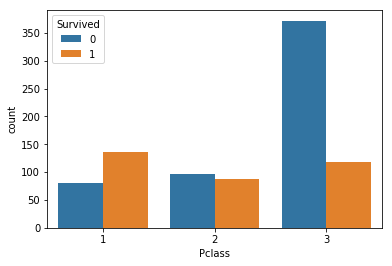

In [5]:
sns.countplot("Pclass", data=df, hue="Survived")

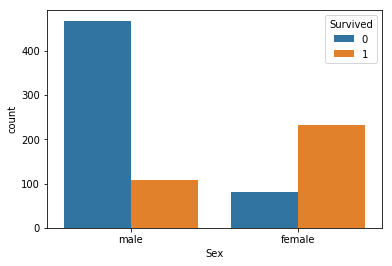

In [6]:
sns.countplot("Sex", data=df, hue="Survived")

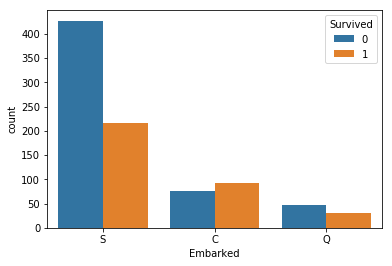

In [7]:
sns.countplot("Embarked", data=df, hue="Survived")

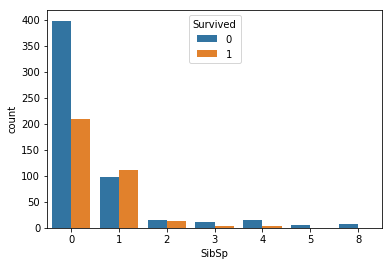

In [8]:
sns.countplot("SibSp", data=df, hue="Survived")

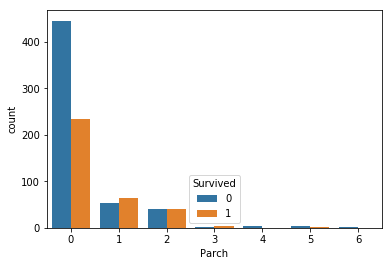

In [9]:
sns.countplot("Parch", data=df, hue="Survived")

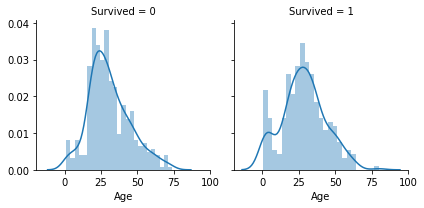

In [10]:
g = sns.FacetGrid(df, col='Survived')
g.map(sns.distplot, 'Age', bins=25)

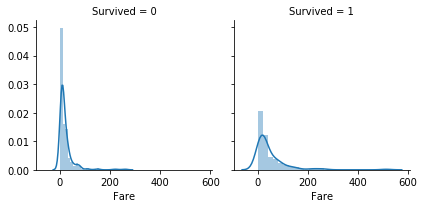

In [11]:
g = sns.FacetGrid(df, col='Survived')
g.map(sns.distplot, 'Fare', bins=25)

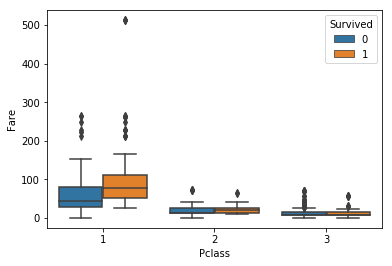

In [12]:
sns.boxplot("Pclass", "Fare", hue="Survived", data=df)

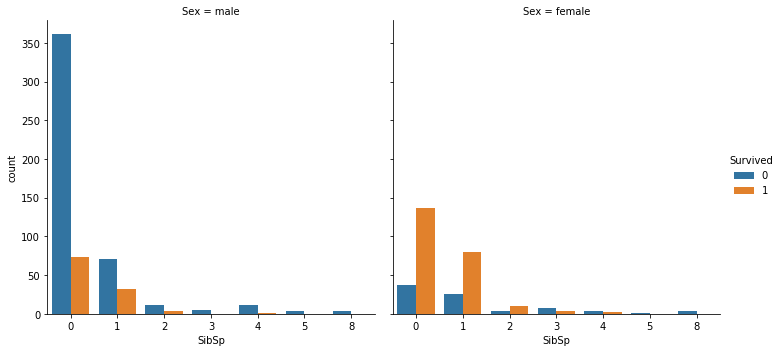

In [13]:
sns.catplot("SibSp", data=df, hue="Survived", col="Sex", kind='count')

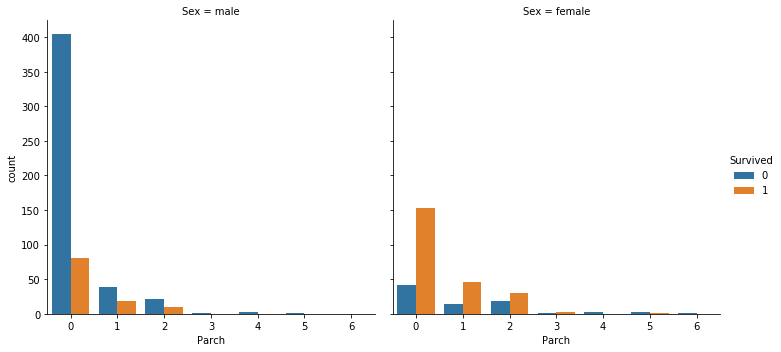

In [14]:
sns.catplot("Parch", data=df, hue="Survived", col="Sex", kind='count')

# Concept 6: Data Leakage and The Proper Workflow

__NOTE__<br>
- Dataset splitting harus dilakukan di awal untuk menghindari _Data Leakage_
- Apapun preprocess yang dilakukan pada data train, dilakukan juga ke data test, tetapi hanya menggunakan informasi dari data train


### 6a. Starts with feature creation (jika ada)

Fitur baru biasa diperoleh melalui insight saat EDA

In [15]:
df["isAlone"] = (df.SibSp == 0) & (df.Parch == 0)
df.isAlone = df.isAlone.apply(lambda x: int(x))
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,isAlone
PassengerId,,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,NaN,S,0
2,1,1,female,38.0,1,0,71.2833,C85,C,0
3,1,3,female,26.0,0,0,7.9250,NaN,S,1
4,1,1,female,35.0,1,0,53.1000,C123,S,0
5,0,3,male,35.0,0,0,8.0500,NaN,S,1


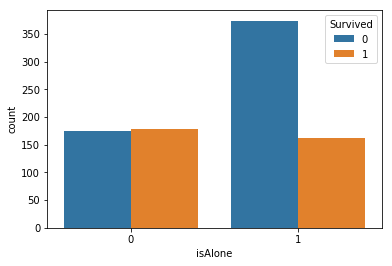

In [16]:
sns.countplot("isAlone", data=df, hue="Survived")

In [17]:
df.Age = pd.cut(df.Age, [0, 5, 12, 18, 40, 120], labels=["balita", "anak-anak", "remaja", "dewasa", "lansia"])
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,isAlone
PassengerId,,,,,,,,,,
1,0,3,male,dewasa,1,0,7.2500,NaN,S,0
2,1,1,female,dewasa,1,0,71.2833,C85,C,0
3,1,3,female,dewasa,0,0,7.9250,NaN,S,1
4,1,1,female,dewasa,1,0,53.1000,C123,S,0
5,0,3,male,dewasa,0,0,8.0500,NaN,S,1


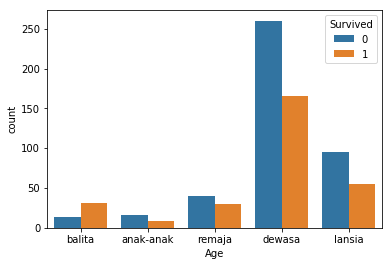

In [18]:
sns.countplot("Age", data=df, hue="Survived")

### 6b. imputation

In [19]:
X = df.iloc[:, 1:]
y = df.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 9), (179, 9), (712,), (179,))

Pclass      0.000000
Sex         0.000000
Age         0.192416
SibSp       0.000000
Parch       0.000000
Fare        0.000000
Cabin       0.775281
Embarked    0.002809
isAlone     0.000000
dtype: float64

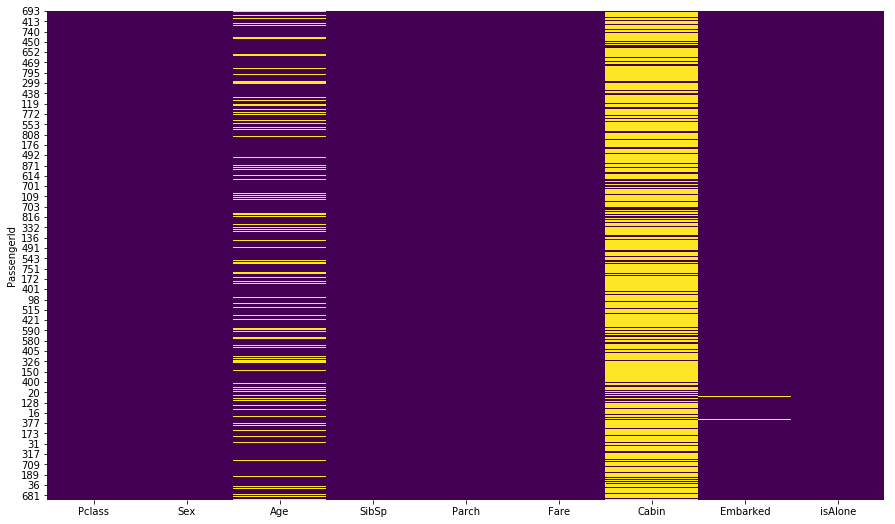

In [20]:
plot_na(X_train)

Pclass      0.000000
Sex         0.000000
Age         0.223464
SibSp       0.000000
Parch       0.000000
Fare        0.000000
Cabin       0.754190
Embarked    0.000000
isAlone     0.000000
dtype: float64

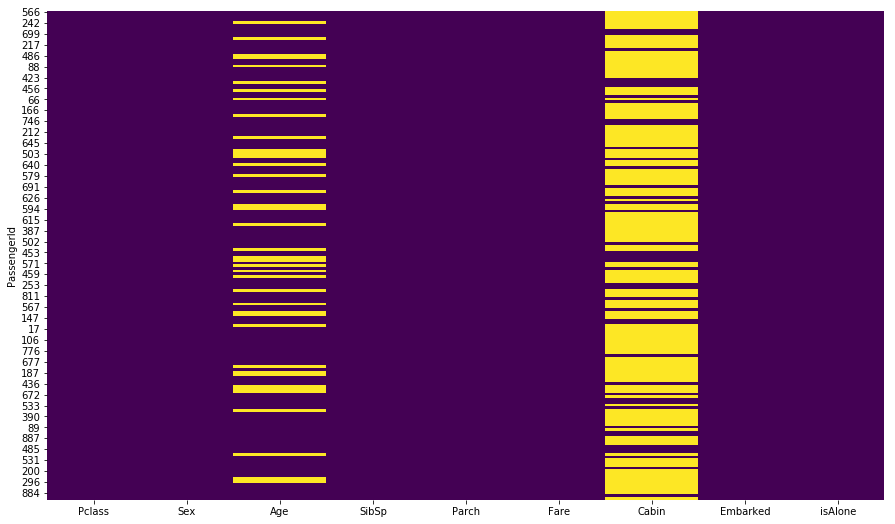

In [21]:
plot_na(X_test)

In [22]:
X_train.drop("Cabin", axis=1, inplace=True)
X_test.drop("Cabin", axis=1, inplace=True)

/opt/pomona/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


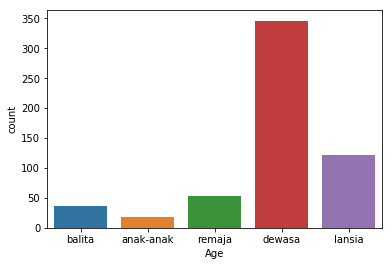

In [23]:
sns.countplot("Age", data=X_train)

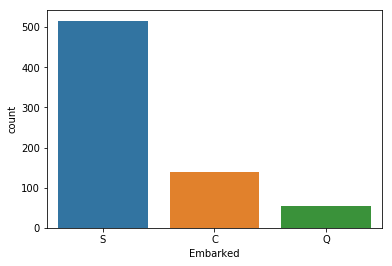

In [24]:
sns.countplot("Embarked", data=X_train)

In [25]:
X_train.fillna({"Age": "dewasa", "Embarked": "S"}, inplace=True)
X_test.fillna({"Age": "dewasa", "Embarked": "S"}, inplace=True)

/opt/pomona/lib/python3.6/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


### 6c. Categorical Feature Engineering

In [26]:
X_train.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
       'isAlone'],
      dtype='object')

__Tips__<br>
kategori non biner ==> `one-hot encoding`<br>
kategori biner ==> `label encoding`

In [27]:
cat_var = ["Pclass", "Embarked", "Age"]
X_train, X_test = get_dummies(X_train, X_test, cat_var)
X_train.head()

,Sex,SibSp,Parch,Fare,isAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Age_anak-anak,Age_balita,Age_dewasa,Age_lansia,Age_remaja
PassengerId,,,,,,,,,,,,,,,,
693,male,0,0,56.4958,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
482,male,0,0,0.0000,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
528,male,0,0,221.7792,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
856,female,0,1,9.3500,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
802,female,1,1,26.2500,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [28]:
X_train.Sex.replace({"male": 0, "female": 1}, inplace=True)
X_test.Sex.replace({"male": 0, "female": 1}, inplace=True)
X_train.head()

,Sex,SibSp,Parch,Fare,isAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Age_anak-anak,Age_balita,Age_dewasa,Age_lansia,Age_remaja
PassengerId,,,,,,,,,,,,,,,,
693,0,0,0,56.4958,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
482,0,0,0,0.0000,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
528,0,0,0,221.7792,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
856,1,0,1,9.3500,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
802,1,1,1,26.2500,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


### 6d. Numerical Feature Engineering

In [29]:
num_var = ["Fare"]
X_train, X_test = yeo_johnson(X_train, X_test, num_var)
X_train.head()

,Sex,SibSp,Parch,Fare,isAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Age_anak-anak,Age_balita,Age_dewasa,Age_lansia,Age_remaja
PassengerId,,,,,,,,,,,,,,,,
693,0,0,0,1.122381,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
482,0,0,0,-3.362410,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
528,0,0,0,2.338465,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
856,1,0,1,-0.608424,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
802,1,1,1,0.396408,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


SibSp dan Parch bisa dibiarkan saja karena orde nya tidak jomplang, tetapi jika ingin menggunakan min-max scaler, atau se-simple dibagi dengan 10 juga boleh dicoba

### 6e. Training

In [30]:
df.Survived.value_counts() / len(df)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

In [31]:
parameter = {
    "n_neighbors": np.arange(1, 31, 2),
    "weights": ['uniform', 'distance'],
    "p": [1, 2]
}
knn = GridSearchCV(KNeighborsClassifier(), param_grid=parameter, cv=5, n_jobs=-1)
knn.fit(X_train, y_train)

print(knn.best_params_)
print(knn.best_score_)
print(knn.score(X_test, y_test))

{'n_neighbors': 11, 'p': 1, 'weights': 'distance'}
0.8160112359550562
0.8044692737430168


/opt/pomona/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


__NOTE__<br>
Walau score kali ini tidak berbeda jauh, tetapi hasil kali ini murni tanpa ada leakage, dan kita bisa confident bahwa score di luar data kita nantinya sekitar 0.788<br>
Apabila seperti di kasus sebelumnya (ada leakage) bisa jadi prediksi di luar data kita jauh dari test score nya

Hal ini juga menjadi alasan lain kenapa kita perlu mulai dengan model yang simple saja dulu. Karena bisa jadi yang simple saja sudah lebih dari cukup. Selain itu, model yang simple bisa kita jadikan benchmark atau acuan untuk model yang lebih kompleks

# Save my model

In [32]:
import pickle

In [33]:
pickle.dump(knn, open("knn2_titanic.pkl", "wb"))

# Example of even how complex you can go

In [33]:
df = pd.read_csv("data/titanic-train.csv", index_col="PassengerId")
df.tail()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [34]:
df.drop("Ticket", axis=1, inplace=True)

In [35]:
df["isAlone"] = (df.SibSp == 0) & (df.Parch == 0)
df.isAlone = df.isAlone.apply(lambda x: int(x))
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,isAlone
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C,0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S,0
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S,1


In [36]:
df.Age = pd.cut(df.Age, [0, 5, 12, 18, 40, 120], labels=["balita", "anak-anak", "remaja", "dewasa", "lansia"])
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,isAlone
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,dewasa,1,0,7.2500,NaN,S,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,dewasa,1,0,71.2833,C85,C,0
3,1,3,"Heikkinen, Miss. Laina",female,dewasa,0,0,7.9250,NaN,S,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,dewasa,1,0,53.1000,C123,S,0
5,0,3,"Allen, Mr. William Henry",male,dewasa,0,0,8.0500,NaN,S,1


In [37]:
df["title"] = df.Name.apply(lambda x: (x.split(", ")[1]).split(".")[0])
df.drop("Name", axis=1, inplace=True)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,isAlone,title
PassengerId,,,,,,,,,,,
1,0,3,male,dewasa,1,0,7.2500,NaN,S,0,Mr
2,1,1,female,dewasa,1,0,71.2833,C85,C,0,Mrs
3,1,3,female,dewasa,0,0,7.9250,NaN,S,1,Miss
4,1,1,female,dewasa,1,0,53.1000,C123,S,0,Mrs
5,0,3,male,dewasa,0,0,8.0500,NaN,S,1,Mr


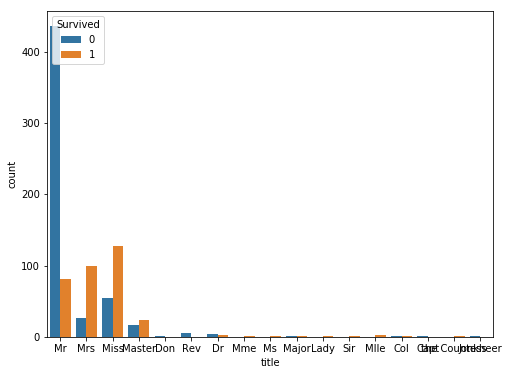

In [38]:
plt.figure(figsize=(8,6))
sns.countplot("title", hue="Survived", data=df)

In [39]:
df.title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [40]:
def modif_title(x):
    if x not in ['Mr', 'Mrs', 'Miss', 'Master']:
        return "other"
    else:
        return x

In [41]:
df.title = df.title.apply(lambda x: modif_title(x))
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,isAlone,title
PassengerId,,,,,,,,,,,
1,0,3,male,dewasa,1,0,7.2500,NaN,S,0,Mr
2,1,1,female,dewasa,1,0,71.2833,C85,C,0,Mrs
3,1,3,female,dewasa,0,0,7.9250,NaN,S,1,Miss
4,1,1,female,dewasa,1,0,53.1000,C123,S,0,Mrs
5,0,3,male,dewasa,0,0,8.0500,NaN,S,1,Mr


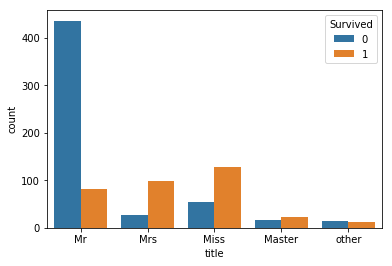

In [42]:
sns.countplot("title", hue="Survived", data=df)

In [43]:
X = df.iloc[:, 1:]
y = df.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# Imputation
X_train.drop("Cabin", axis=1, inplace=True)
X_test.drop("Cabin", axis=1, inplace=True)
X_train.fillna({"Age": "dewasa", "Embarked": "S"}, inplace=True)
X_test.fillna({"Age": "dewasa", "Embarked": "S"}, inplace=True)

# Categorical Feature Engineering
cat_var = ["Pclass", "Embarked", "Age", "title"]
X_train, X_test = get_dummies(X_train, X_test, cat_var)

X_train.Sex.replace({"male": 0, "female": 1}, inplace=True)
X_test.Sex.replace({"male": 0, "female": 1}, inplace=True)

# Numerical Feature Engineering
num_var = ["Fare"]
X_train, X_test = yeo_johnson(X_train, X_test, num_var)

/opt/pomona/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/opt/pomona/lib/python3.6/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [44]:
parameter = {
    "n_neighbors": np.arange(1, 31, 2),
    "weights": ['uniform', 'distance'],
    "p": [1, 2]
}
knn = GridSearchCV(KNeighborsClassifier(), param_grid=parameter, cv=5, n_jobs=-1)
knn.fit(X_train, y_train)

print(knn.best_params_)
print(knn.best_score_)
print(knn.score(X_test, y_test))

{'n_neighbors': 11, 'p': 1, 'weights': 'uniform'}
0.8216292134831461
0.8379888268156425


In [45]:
import pickle
pickle.dump(knn, open("knn3_titanic.pkl", "wb"))

# Concept 7: Benchmark and Kaggle

Cara paling simple untuk mendapatkan batas bawah dari score adalah menggunakan model yang paling simple seperti random guessing, atau simple threshold saat EDA.<br>
Lebih baik lagi adalah sistem kompetisi seperti Kaggle. I'll explain more about it.

### Random Guessing

In [46]:
df = pd.read_csv("data/titanic-train.csv", index_col="PassengerId")

X = df.iloc[:, 1:]
y = df.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 10), (179, 10), (712,), (179,))

In [47]:
random_pred_train = np.random.randint(0, 2, len(y_train))
random_pred_test = np.random.randint(0, 2, len(y_test))
print(accuracy_score(y_train, random_pred_train))
print(accuracy_score(y_test, random_pred_test))

0.49719101123595505
0.5139664804469274


### Simple Threshold

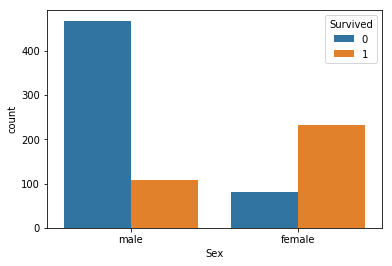

In [48]:
sns.countplot("Sex", hue="Survived", data=df)
# Male did not survive, Female survived

In [49]:
pred_train = X_train.Sex.replace({"male": 0, "female": 1})
pred_test = X_test.Sex.replace({"male": 0, "female": 1})
print(accuracy_score(y_train, pred_train))
print(accuracy_score(y_test, pred_test))

0.7893258426966292
0.776536312849162


### Competition

Coba pikirkan, banyak sekali hal yang masih bisa dicoba
- bagaimana kalau Age tidak kita bin ?
- bagaimana kalau kita tidak pakai Embarked ?
- bagaimana kalau kita pakai algoritma selain knn ?

Karena begitu banyaknya yang bisa dicoba, sistem kompetisi bisa mengumpulkan banyak orang dan model berbeda untuk solve suatu masalah yang kemudian model terbaiknya digunakan sebagai ganti reward (biasanya uang)